In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from koopmaneigen.koopman_eigensolver_dmd import KoopmanEigenSolversDMD
from koopmaneigen.linearsystem import Linear2dSystem

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis, TSCIdentity

In [3]:
import ipynbname
import os
nb_fname = ipynbname.name()
nb_path = ipynbname.path()
nb_fname

if not os.path.exists(f"plots/{nb_fname}"):
    os.makedirs(f"plots/{nb_fname}")


In [4]:
plt.rcParams['text.usetex'] = True #
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

### set up linear system Koopman matrix using EDMD

In [5]:
A = np.array([[0.9, -0.1], [0, 0.8]])

eigvalue_i = 0.9
eigvalue_j = 0.8

def eigenfunction_i(x,y):
    return (x-y)/np.sqrt(2)

def eigenfunction_j(x,y):
    return y    

linear_system = Linear2dSystem(A, eigvalue_i, eigvalue_j, eigenfunction_i, eigenfunction_j)

In [6]:
initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
).T.reshape(-1, 2)


initial_conditions.shape

(400, 2)

In [7]:
tsc_data = linear_system.sample_system(initial_conditions)
print(tsc_data.shape)
tsc_data.head()

(800, 2)


feature        x1        x2
ID time                    
0  0    -2.000000 -2.000000
   1    -1.600000 -1.600000
1  0    -2.000000 -1.789474
   1    -1.621053 -1.431579
2  0    -2.000000 -1.578947

#### Approximate Koopman matrix using DMD

In [8]:
dmd = DMDFull().fit(X=tsc_data, store_system_matrix=True)  # must be TSCDataFrame
dmd_values = dmd.predict(tsc_data.initial_states(), time_values=None)

# Will be a red line in the plot
dmd_values_oos = dmd.predict(np.array([-1.8, 2]), time_values=np.arange(0,10))

print("Data snipped with predicted time series data")
dmd_values

Data snipped with predicted time series data


feature         x1        x2
ID  time                    
0   0    -2.000000 -2.000000
    1    -1.600000 -1.600000
1   0    -2.000000 -1.789474
    1    -1.621053 -1.431579
2   0    -2.000000 -1.578947
...            ...       ...
397 1     1.642105  1.263158
398 0     2.000000  1.789474
    1     1.621053  1.431579
399 0     2.000000  2.000000
    1     1.600000  1.600000

[800 rows x 2 columns]

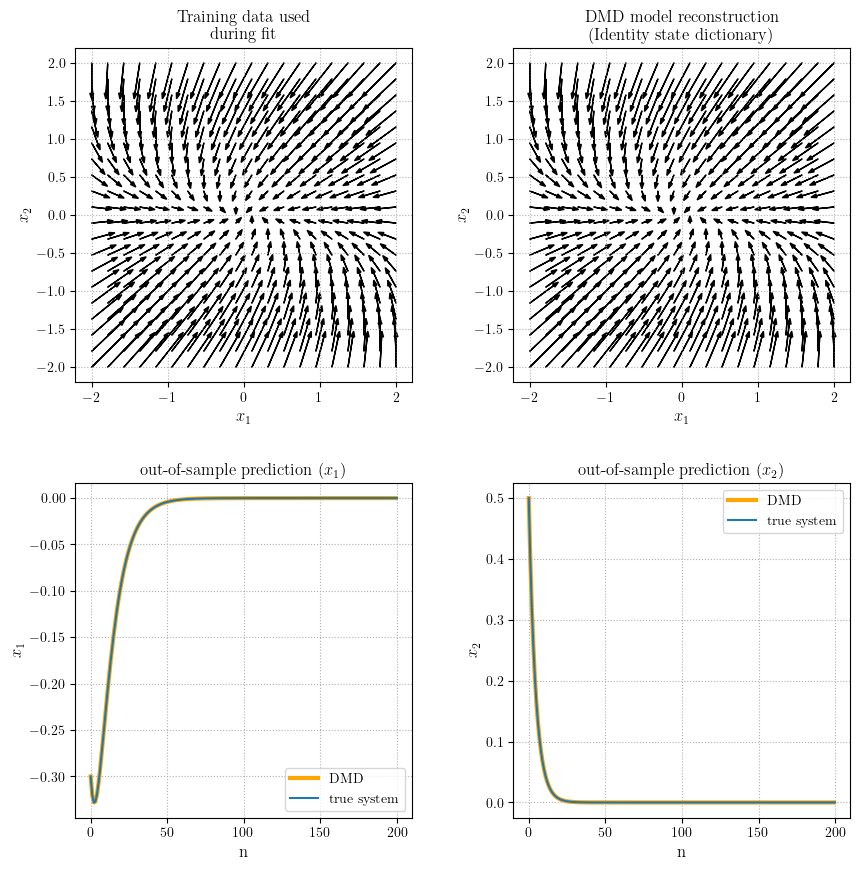

In [9]:
def include_arrow(ax, df, color="black", hw = 0.05):
        ax.arrow(
            df.iloc[-2, 0],
            df.iloc[-2, 1],
            dx=df.iloc[-1, 0] - df.iloc[-2, 0],
            dy=df.iloc[-1, 1] - df.iloc[-2, 1],
            color=color,
            head_width=hw,
        )
  
f, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for _id, df in tsc_data.itertimeseries():
    ax[0][0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][0], df)
    
ax[0][0].set_title("Training data used\n during fit")
ax[0][0].set_xlabel(r"$x_1$", fontsize=12)
ax[0][0].set_ylabel(r"$x_2$",fontsize=12)
ax[0][0].axis("equal")
ax[0][0].grid(linestyle='dotted')

for _id, df in dmd_values.itertimeseries():
    ax[0][1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][1], df)

ax[0][1].set_title("DMD model reconstruction\n(Identity state dictionary)")
ax[0][1].set_xlabel(r"$x_1$", fontsize=12)
ax[0][1].set_ylabel(r"$x_2$", fontsize=12)
ax[0][1].axis("equal")
ax[0][1].grid(linestyle='dotted')


# generate red "out-of-sample" prediction, for extra analysis below
# ax[0][1].plot(dmd_values_oos["x1"], dmd_values_oos["x2"], 0.1, c="orange", label="oos prediction")
# include_arrow(ax[0][1], dmd_values_oos, color="orange", hw = 0.09)
# ax[0][1].legend()

# compare oos prediction
initial_condition = np.array([[-0.3, 0.5]])

ground_truth = linear_system.generate_trajectory(initial_condition, n_steps=200)
predicted = dmd.predict(initial_condition, np.arange(0,200))

ax[1][0].plot(range(predicted.shape[0]), predicted["x1"], c="orange", label="DMD", linewidth=3)
ax[1][0].plot(range(ground_truth.shape[0]), ground_truth.loc[:, "x1"], label="true system")

ax[1][0].set_title("out-of-sample prediction ($x_1$)")
ax[1][0].set_xlabel("n", fontsize=12)
ax[1][0].set_ylabel(r"$x_1$", fontsize=12)
ax[1][0].grid(linestyle='dotted')
ax[1][0].legend()

ax[1][1].plot(range(predicted.shape[0]), predicted["x2"], c="orange", label="DMD", linewidth=3)
ax[1][1].plot(range(ground_truth.shape[0]), ground_truth.loc[:, "x2"], label="true system")

ax[1][1].set_title("out-of-sample prediction ($x_2$)")
ax[1][1].set_xlabel("n", fontsize=12)
ax[1][1].set_ylabel(r"$x_2$", fontsize=12)
ax[1][1].grid(linestyle='dotted')
ax[1][1].legend()

plt.savefig(f"plots/{nb_fname}/DMD_linear_system.pdf", bbox_inches='tight', dpi=300)
plt.show()

#### plot explicit koopman eigenfunctions of the linear system

In [10]:
sorted_eig = linear_system.get_sorted_eigvalues(max_exponent_sum=5)
sorted_eig

[(1, 0),
 (2, 0),
 (0, 1),
 (3, 0),
 (1, 1),
 (4, 0),
 (2, 1),
 (0, 2),
 (5, 0),
 (3, 1),
 (1, 2),
 (4, 1),
 (2, 2),
 (0, 3),
 (3, 2),
 (1, 3),
 (2, 3),
 (0, 4),
 (1, 4),
 (0, 5)]

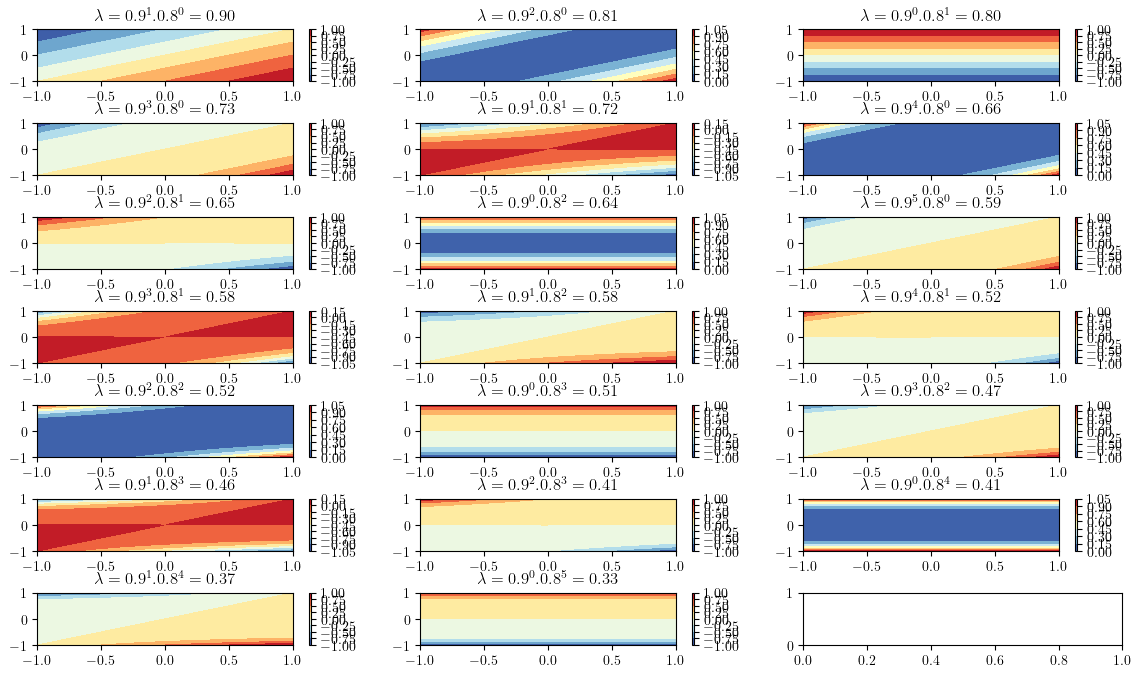

In [11]:
f, ax = plt.subplots(len(sorted_eig)//3 + 1, 3, figsize=(14, 8))
plt.subplots_adjust(hspace=0.8)

# define grid range
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
    
for i, (m,n) in enumerate(sorted_eig):
    linear_system.plot_eigenfunction_contour(x=x, y=y, m=m, n=n, ax = ax[int(i/3)][i%3])
    eig = (eigvalue_i)**m * (eigvalue_j) ** n
    eig_str = f"$\lambda = {eigvalue_i}^{m} . {eigvalue_j}^{n} = {eig:0.2f}$"
    ax[int(i/3)][i%3].set_title(eig_str)



### plot Koopman eigenfunctions computed using left eigenvectors

In [12]:
koopman_eigen_dmd = KoopmanEigenSolversDMD(dmd, tsc_data)
print("shape of koopman matrix: ", koopman_eigen_dmd.koopman_matrix.shape)

shape of koopman matrix:  (2, 2)


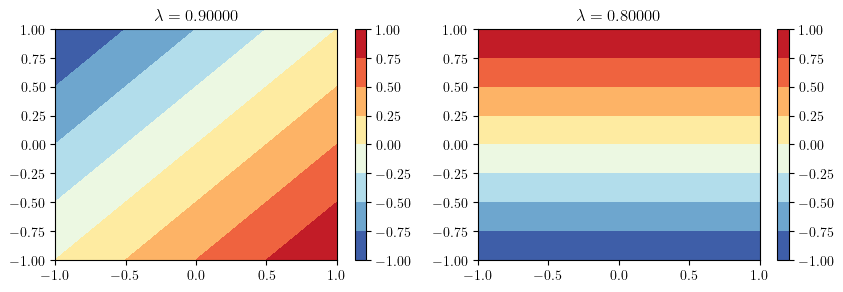

In [13]:
f, ax = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(hspace=0.6)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()
x = np.array([X.flatten(), Y.flatten()]).T

koopman_eigenfunctions_eval = koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs)(x)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    
    Z = koopman_eigenfunctions_eval[:, i]
    Z = Z/np.max(np.abs(Z))
    
    h = ax[i].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r')
    eig = koopman_eigen_dmd.left_koopman_eigvals[i]

    ax[i].set_title(f"$\lambda = {eig:.5f}$")
    plt.colorbar(h)    

In [14]:
# trajectory error
np.linalg.norm(koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs[:,1])((A@x.T).T) 
               - koopman_eigen_dmd.left_koopman_eigvals[1] * 
               koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs[:,1])(x))

3.854379120560698e-14

#### extend eigenfunctions using two left eigenvectors

In [15]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x.shape)
koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=2, pow_j=4)

(100,)


array([2.93419279e-29, 1.02030405e-04, 4.08121620e-04, ...,
       4.08121620e-04, 1.02030405e-04, 2.93419279e-29])

#### compare extended eigenfunctions with explicit eigenfunctions

In [16]:
# take increasing powers of second eigenfunctions to compare
sorted_eig = linear_system.get_sorted_eigvalues(max_exponent_sum=10)

In [17]:
def compute_c_error(Z, Z_l):
    
    tol = 1e-16
    Z = Z.flatten()
    Z_l = Z_l.flatten()
    z_0 = np.logical_or((np.abs(Z) <tol), (np.abs(Z_l) <tol))


    unique_values, value_counts = np.unique(Z[~z_0]/ Z_l[~z_0], return_counts=True)
    
    # Get the mode value and count
    c_mode = unique_values[np.argmax(value_counts)]
    c_mode_count = value_counts[np.argmax(value_counts)]
    
    error = np.linalg.norm(Z  - c_mode*Z_l)
    return error

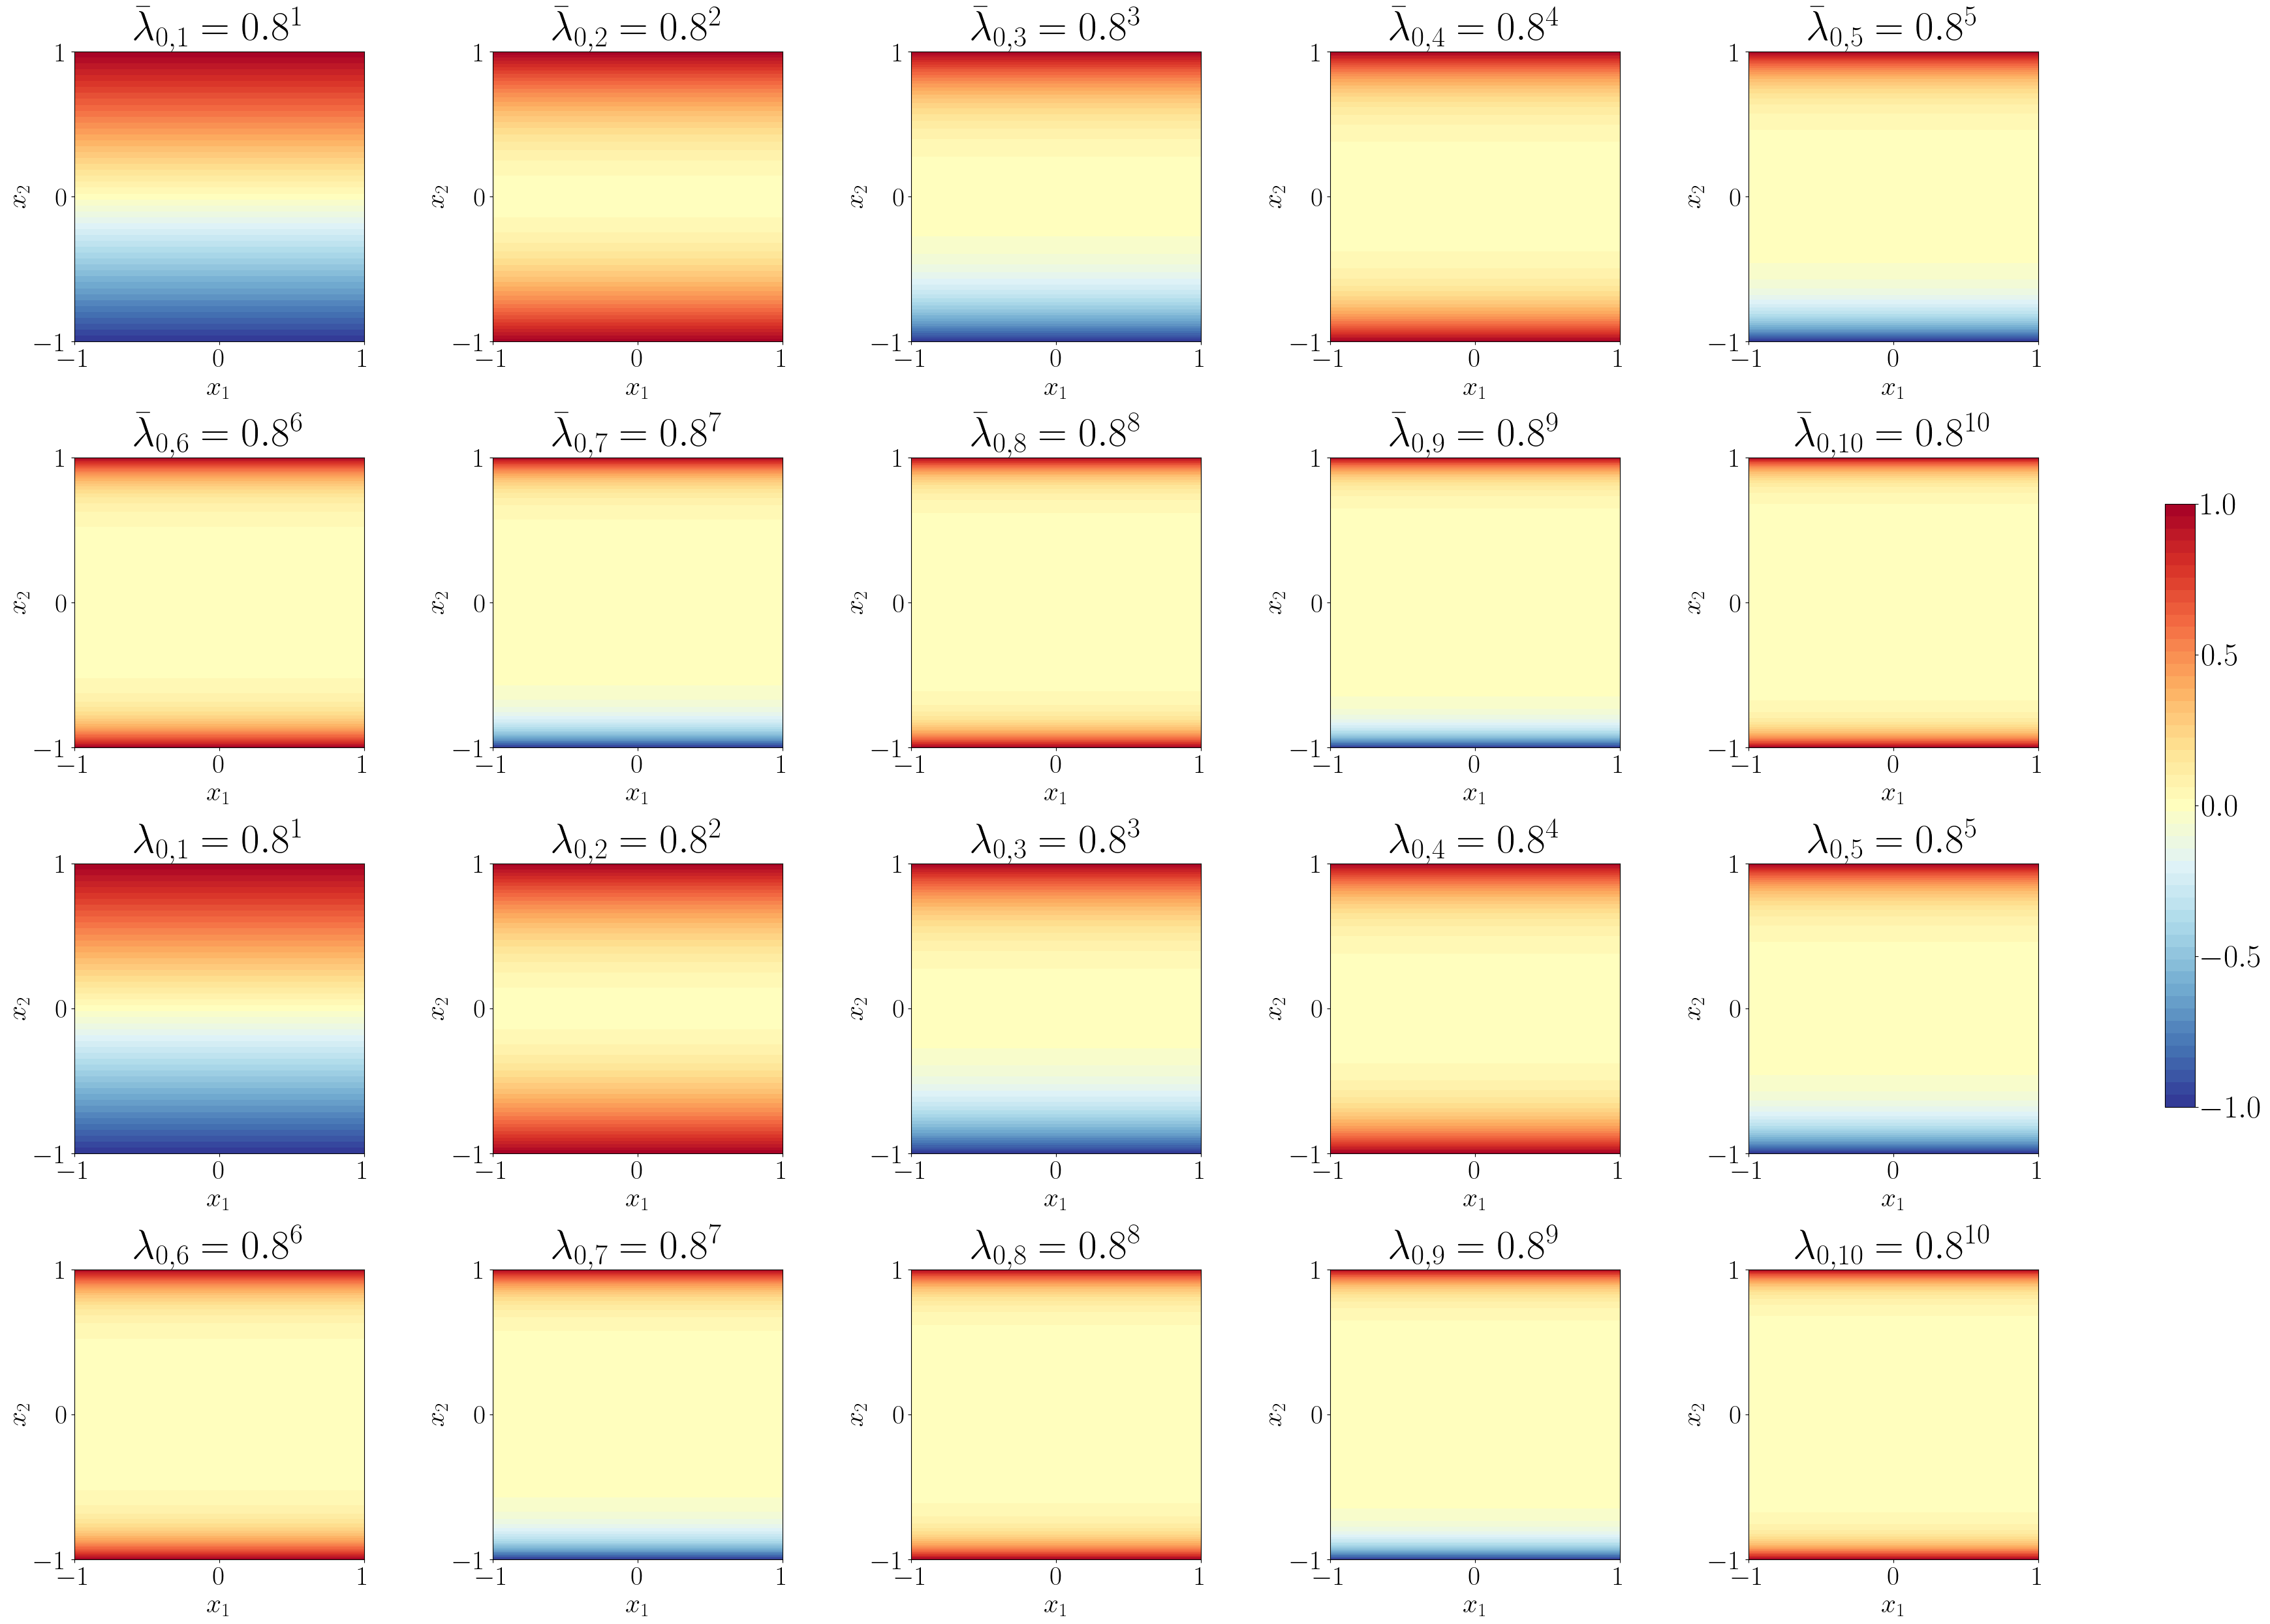

In [19]:
f, ax = plt.subplots(4, 5, figsize=(50,30))
plt.subplots_adjust(hspace=0.4)
error_list = []

c = 0
for i, (m,n) in enumerate(sorted_eig):
    Z_l = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=m, pow_j=n, 
                                                  normalize=False)
    
    Z_l_t = koopman_eigen_dmd.extend_eigenfunctions((A@(x_flat.T)).T, eigenvector_indexes=[0,1], pow_i=m, pow_j=n, 
                                                  normalize=False)
    
    Z_l_t = Z_l_t.reshape(X.shape)
    Z_l = Z_l.reshape(X.shape)
    
    
    Z_l_norm = Z_l/np.max(np.abs(Z_l))
    
    eigvalue_i_c = koopman_eigen_dmd.left_koopman_eigvals[0]
    eigvalue_j_c = koopman_eigen_dmd.left_koopman_eigvals[1]
    eig_c = (eigvalue_i_c)**m * (eigvalue_j_c) ** n
    
    traj_error = np.linalg.norm(Z_l_t - eig_c*Z_l)/np.sqrt(x.shape[0])
    rel_traj_error = traj_error/np.linalg.norm(Z_l_t)
    
    if m ==0:
        eig_str_c = "$\\bar{\lambda}_{" + f"{m},{n}" + "}" +f"= {eigvalue_j_c:.3}^{{" + f"{n}" + "}$"
        row = 1 if c>4 else 0
        h = ax[row][c%5].contourf(X, Y, Z_l_norm, cmap='RdYlBu_r', levels=np.linspace(-1, 1, 50))
#         plt.colorbar(h, orientation='horizontal')
        ax[row][c%5].set_title(eig_str_c, fontsize=45)
        ax[row][c%5].set_xticks([ax[row][c%5].get_xlim()[0], 0, ax[row][c%5].get_xlim()[1]])
        ax[row][c%5].set_yticks([ax[row][c%5].get_ylim()[0], 0, ax[row][c%5].get_ylim()[1]])
        ax[row][c%5].tick_params(axis='both', which='major', labelsize=30)
        ax[row][c%5].set_xlabel("$x_1$", fontsize=30)
        ax[row][c%5].set_ylabel("$x_2$", fontsize=30)
        ax[row][c%5].set_aspect('equal')

    Z = linear_system.generate_eigenfunction(X, Y, m,n)
    Z_norm = Z/np.max(np.abs(Z))
    
    eig = (eigvalue_i)**m * (eigvalue_j) ** n

    if m ==0:
        eig_str = "$\lambda_{" + f"{m},{n}" + "}"  +f"= {eigvalue_j:.3}^{{" + f"{n}" + "}$"

        row = 3 if c>4 else 2
        h = ax[row][c%5].contourf(X, Y, Z_norm, cmap='RdYlBu_r', levels=np.linspace(-1, 1, 50))#, vmin=-1, vmax=1)
#       plt.colorbar(h)
    
        ax[row][c%5].set_title(eig_str, fontsize=45)
        ax[row][c%5].set_xticks([ax[row][c%5].get_xlim()[0], 0, ax[row][c%5].get_xlim()[1]])
        ax[row][c%5].set_yticks([ax[row][c%5].get_ylim()[0], 0, ax[row][c%5].get_ylim()[1]])
        ax[row][c%5].tick_params(axis='both', which='major', labelsize=30)
        ax[row][c%5].set_xlabel("$x_1$", fontsize=30)
        ax[row][c%5].set_ylabel("$x_2$", fontsize=30)
        ax[row][c%5].set_aspect('equal')

        c=c+1
    
    error = min(np.linalg.norm(Z - Z_l), np.linalg.norm(Z + Z_l))
    error_list.append({"m": m, "n":n, "error": error, "traj_error": traj_error, 
                       "c_error":compute_c_error(Z, Z_l), "rel_traj_error": rel_traj_error})

cbar = f.colorbar(h, ax=ax.ravel().tolist(), shrink=0.4)
cbar.ax.tick_params(labelsize=35)
cbar.set_ticks(np.arange(-1, 1.2, 0.5))

plt.savefig(f"plots/{nb_fname}/DMD_extended_eigfuncs_powers_q.pdf", bbox_inches='tight')
plt.show()

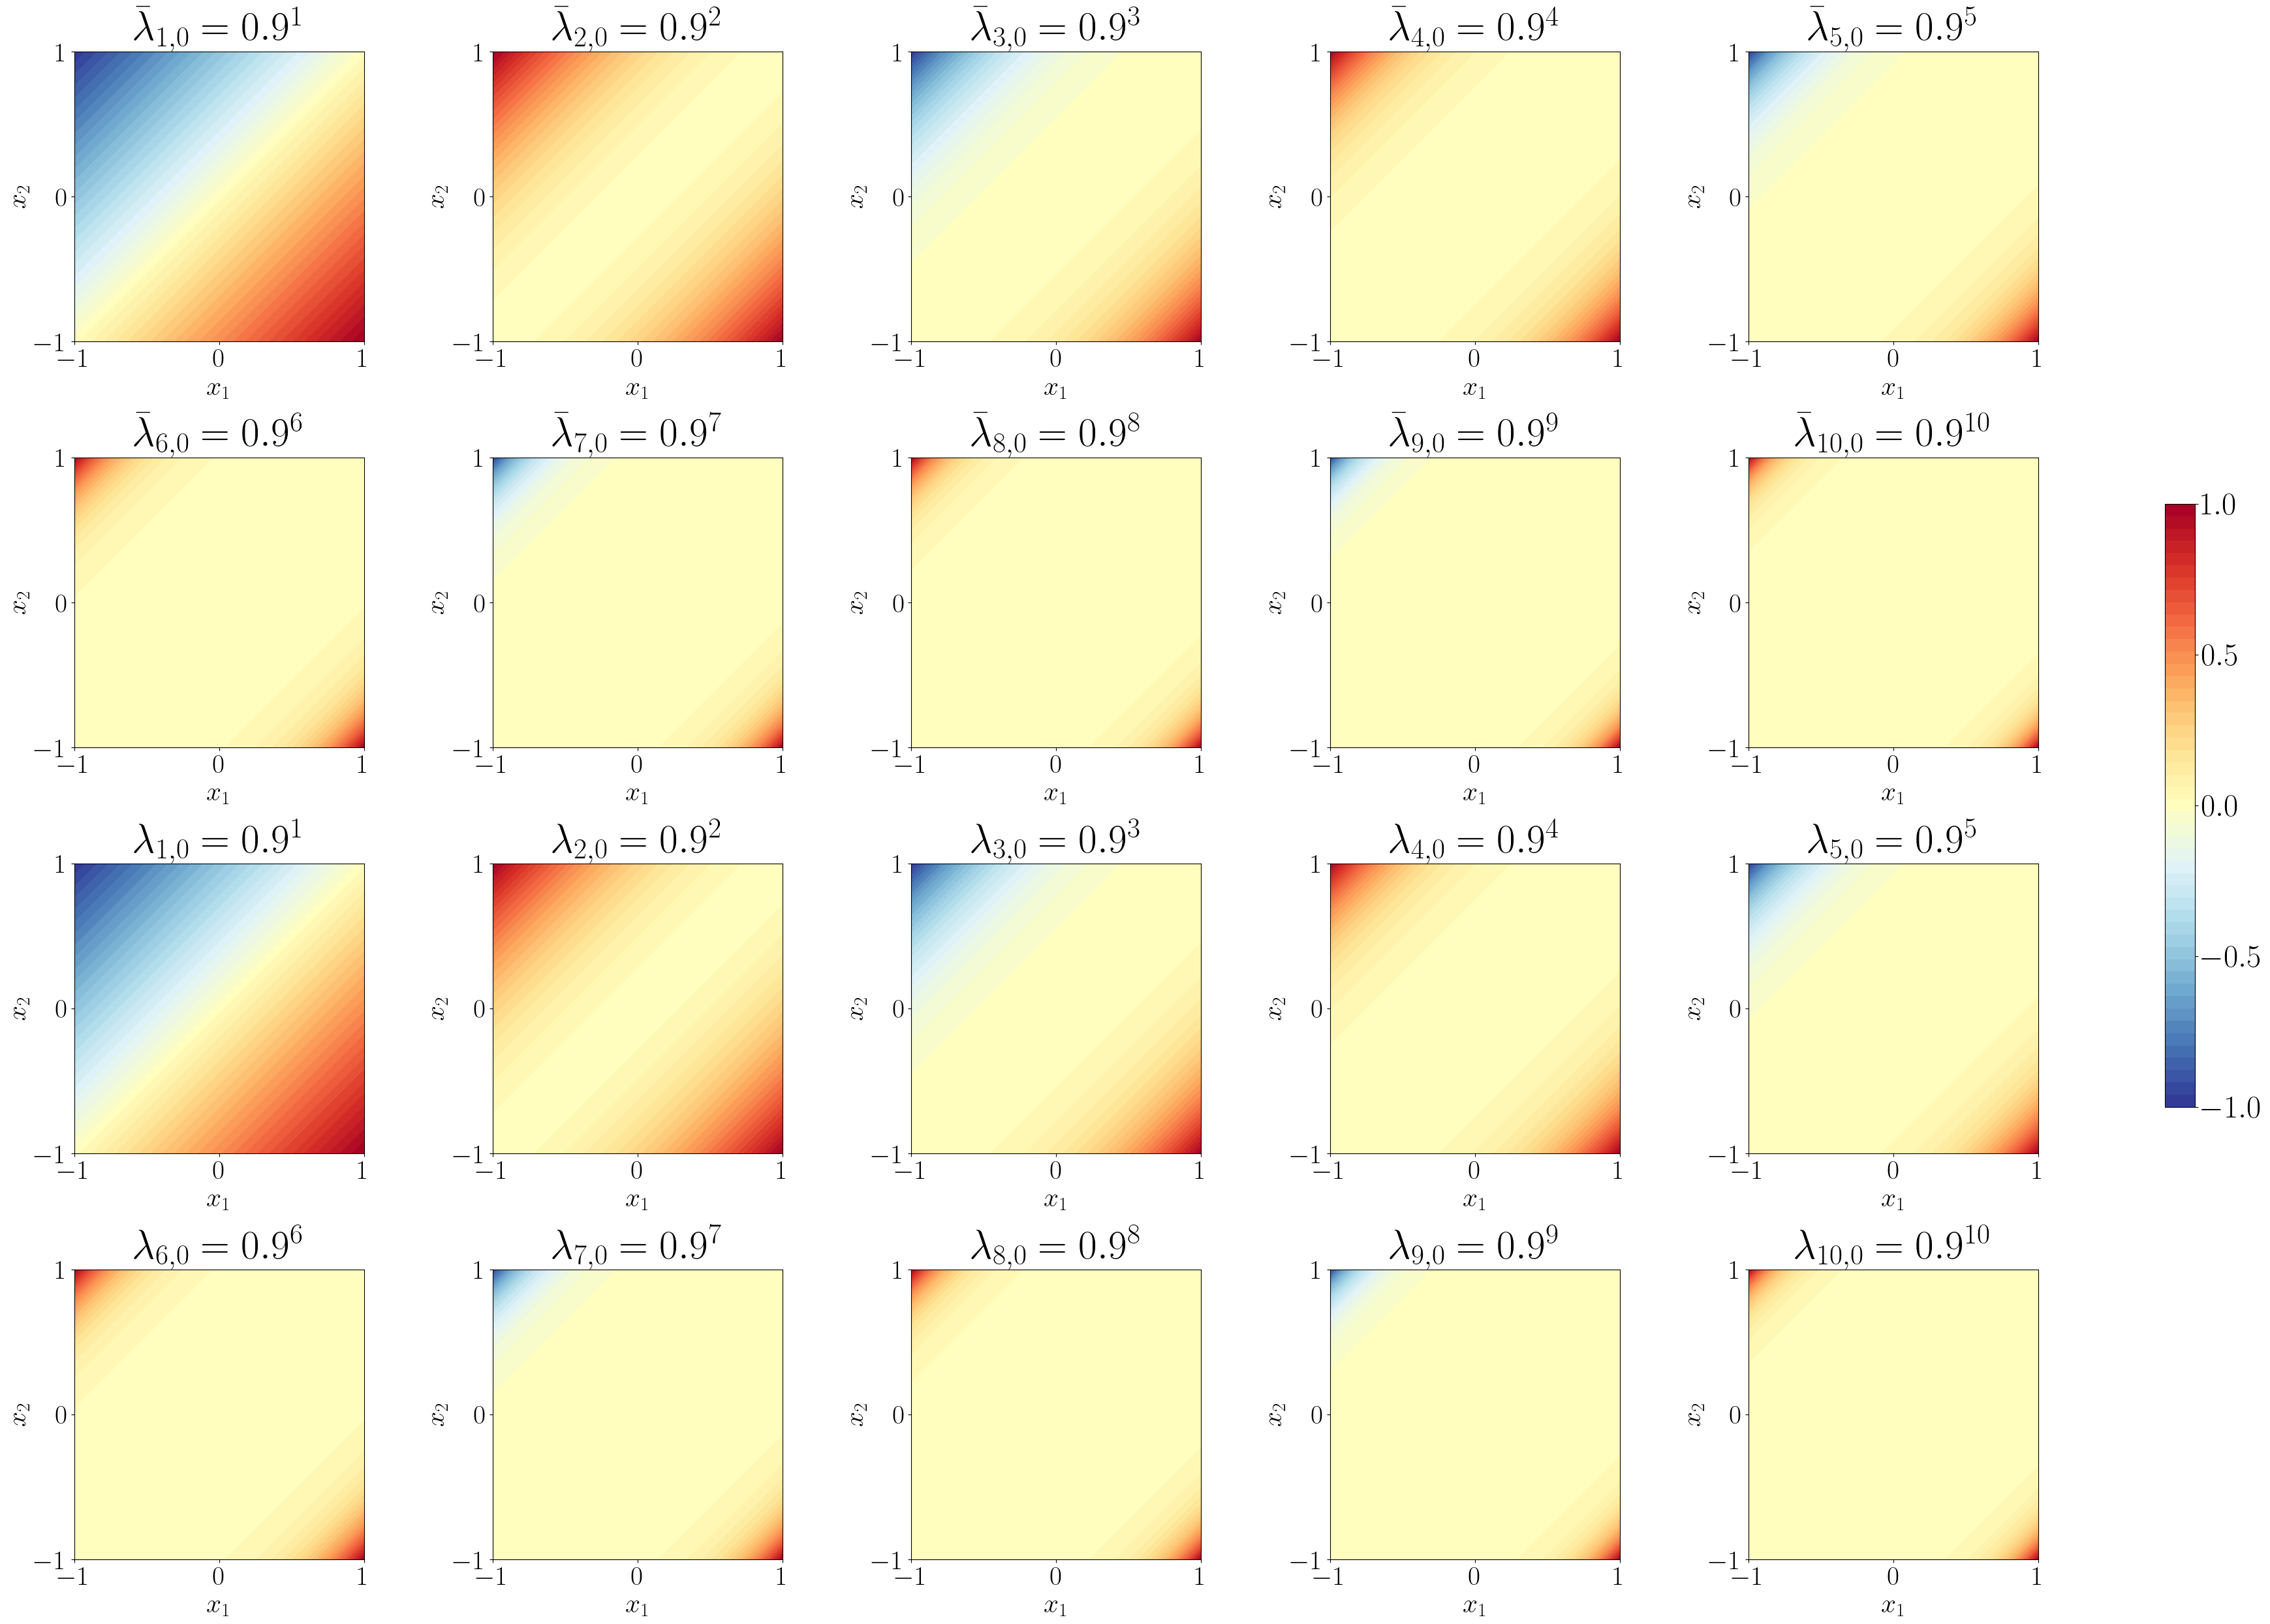

In [20]:
f, ax = plt.subplots(4, 5, figsize=(50,30))
plt.subplots_adjust(hspace=0.4)
error_list = []

c = 0
for i, (m,n) in enumerate(sorted_eig):
    Z_l = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=m, pow_j=n, 
                                                  normalize=False)
    
    Z_l_t = koopman_eigen_dmd.extend_eigenfunctions((A@(x_flat.T)).T, eigenvector_indexes=[0,1], pow_i=m, pow_j=n, 
                                                  normalize=False)
    
    Z_l_t = Z_l_t.reshape(X.shape)
    
    Z_l = Z_l.reshape(X.shape)
    Z_l_norm = Z_l/np.max(np.abs(Z_l))
    
    eigvalue_i_c = koopman_eigen_dmd.left_koopman_eigvals[0]
    eigvalue_j_c = koopman_eigen_dmd.left_koopman_eigvals[1]
    eig_c = (eigvalue_i_c)**m * (eigvalue_j_c) ** n
#     
    traj_error = np.linalg.norm(Z_l_t - eig_c*Z_l)/np.sqrt(x.shape[0])
    np.linalg.norm(Z_l_t - eig_c*Z_l)/np.sqrt(x.shape[0])
    
    
    rel_traj_error = traj_error/np.linalg.norm(Z_l_t)
    const_bound = None       
    
    
    if n ==0:
        eig_str_c = "$\\bar{\lambda}_{" + f"{m},{n}" + "}" +f"= {eigvalue_i_c:.3}^{{" + f"{m}" + "}$"
        row = 1 if c>4 else 0
        h = ax[row][c%5].contourf(X, Y, Z_l_norm, cmap='RdYlBu_r', levels=np.linspace(-1, 1, 50))
#         plt.colorbar(h, orientation='horizontal')
        ax[row][c%5].set_title(eig_str_c, fontsize=45)
        ax[row][c%5].set_xticks([ax[row][c%5].get_xlim()[0], 0, ax[row][c%5].get_xlim()[1]])
        ax[row][c%5].set_yticks([ax[row][c%5].get_ylim()[0], 0, ax[row][c%5].get_ylim()[1]])
        ax[row][c%5].tick_params(axis='both', which='major', labelsize=30)
        ax[row][c%5].set_xlabel("$x_1$", fontsize=30)
        ax[row][c%5].set_ylabel("$x_2$", fontsize=30)
        ax[row][c%5].set_aspect('equal')

    Z = linear_system.generate_eigenfunction(X, Y, m,n)
    Z_norm = Z/np.max(np.abs(Z))
    
    eig = (eigvalue_i)**m * (eigvalue_j) ** n

    if n ==0:
        eig_str = "$\lambda_{" + f"{m},{n}" + "}"  +f"= {eigvalue_i:.3}^{{" + f"{m}" + "}$"

        row = 3 if c>4 else 2
        h = ax[row][c%5].contourf(X, Y, Z_norm, cmap='RdYlBu_r', levels=np.linspace(-1, 1, 50))
#         plt.colorbar(h, orientation='horizontal')
    
        ax[row][c%5].set_title(eig_str, fontsize=45)
        ax[row][c%5].set_xticks([ax[row][c%5].get_xlim()[0], 0, ax[row][c%5].get_xlim()[1]])
        ax[row][c%5].set_yticks([ax[row][c%5].get_ylim()[0], 0, ax[row][c%5].get_ylim()[1]])
        ax[row][c%5].tick_params(axis='both', which='major', labelsize=30)
        ax[row][c%5].set_xlabel("$x_1$", fontsize=30)
        ax[row][c%5].set_ylabel("$x_2$", fontsize=30)
        ax[row][c%5].set_aspect('equal')

        c=c+1
    
    error = min(np.linalg.norm(Z - Z_l), np.linalg.norm(Z + Z_l))
    error_list.append({"m": m, "n":n, "error": error, "traj_error": traj_error, 
                       "c_error":compute_c_error(Z, Z_l), "rel_traj_error": rel_traj_error})
cbar = f.colorbar(h, ax=ax.ravel().tolist(), shrink=0.4)
cbar.ax.tick_params(labelsize=35)
cbar.set_ticks(np.arange(-1, 1.2, 0.5))

plt.savefig(f"plots/{nb_fname}/DMD_extended_eigfuncs_powers_p.pdf", bbox_inches='tight')
plt.show()

### checking if eigenvectors lie in span

map from eigenvector space to function space, take power and map back to eigenvector space

In [21]:
x_flat.shape

(10000, 2)

In [22]:
eigfunc = koopman_eigen_dmd.extend_eigenfunctions(tsc_data, eigenvector_indexes=[0,1], pow_i=0, pow_j=2, 
                                                  normalize=True)
eigvec_new, residual, _, _ = np.linalg.lstsq(np.array(tsc_data) , np.array(eigfunc), rcond=1e-8)
eigvec_new, residual

(array([-2.35685063e-18, -5.36183519e-17]), array([137.29779385]))

In [23]:
eigfunc = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=0, pow_j=2, 
                                                  normalize=True)
eigvec_new, residual, _, _ = np.linalg.lstsq(np.array(x_flat) , np.array(eigfunc), rcond=1e-8)
eigvec_new, residual

(array([ 7.23454736e-17, -2.47497673e-17]), array([2081.34674638]))

In [24]:
m_pow_residual_dict = {}
for m in range(1, 11):
    eigfunc = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=m, pow_j=0, 
                                                  normalize=True)
    eigvec_new, residual, _, _ = np.linalg.lstsq(x_flat , np.array(eigfunc), rcond=1e-8)
    eigvec_new, residual
    m_dict = {"residual": residual[0]}
    
    if residual<1:
        eigval_approx = koopman_eigen_dmd.left_koopman_eigvals[0] ** m
        eig_eq_norm = np.linalg.norm(koopman_eigen_dmd.koopman_matrix.T@eigvec_new - eigval_approx*eigvec_new)
        m_dict["eig_eq_norm"] = eig_eq_norm
    m_pow_residual_dict[m] = m_dict

        
    
n_pow_residual_dict = {}
for n in range(1, 11):
    eigfunc = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=0, pow_j=n, 
                                                  normalize=True)
    eigvec_new, residual, _, _ = np.linalg.lstsq(x_flat , np.array(eigfunc), rcond=1e-8)
    eigvec_new, residual
    n_dict = {"residual": residual[0]}
    
    if residual<1:
        eigval_approx = koopman_eigen_dmd.left_koopman_eigvals[1] ** n
        eig_eq_norm = np.linalg.norm(koopman_eigen_dmd.koopman_matrix.T@eigvec_new - eigval_approx*eigvec_new)
        n_dict["eig_eq_norm"] = eig_eq_norm
    n_pow_residual_dict[n] = n_dict

In [25]:
df = pd.DataFrame(m_pow_residual_dict).T
df.insert(0, "power p", df.index)
latex_table = df.to_latex(na_rep="-", index=False)

# Print the LaTeX table
print(latex_table)

\begin{tabular}{rrr}
\toprule
 power p &     residual &  eig\_eq\_norm \\
\midrule
       1 & 4.908912e-25 & 1.332268e-15 \\
       2 & 6.938401e+02 &            - \\
       3 & 9.603623e+01 &            - \\
       4 & 2.406468e+02 &            - \\
       5 & 8.279875e+01 &            - \\
       6 & 1.237877e+02 &            - \\
       7 & 6.167356e+01 &            - \\
       8 & 7.656635e+01 &            - \\
       9 & 4.639823e+01 &            - \\
      10 & 5.272445e+01 &            - \\
\bottomrule
\end{tabular}



In [26]:
df = pd.DataFrame(n_pow_residual_dict).T
df.insert(0, "power q", df.index)
latex_table = df.to_latex(na_rep="-", index=False)

# Print the LaTeX table
print(latex_table)

\begin{tabular}{rrr}
\toprule
 power q &     residual &  eig\_eq\_norm \\
\midrule
       1 & 3.442032e-27 & 1.040573e-17 \\
       2 & 2.081347e+03 &            - \\
       3 & 2.424390e+02 &            - \\
       4 & 1.202693e+03 &            - \\
       5 & 3.272690e+02 &            - \\
       6 & 8.655758e+02 &            - \\
       7 & 3.393607e+02 &            - \\
       8 & 6.877325e+02 &            - \\
       9 & 3.310601e+02 &            - \\
      10 & 5.781470e+02 &            - \\
\bottomrule
\end{tabular}



In [27]:
# if residual is too high and we get zero solution it means that the eigenfunction does not lie in the span of x1,x2

In [28]:
# also means that there is no 2d vector which can make the given eigenfunction as eigenfunction

### Error bounds

In [29]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x.shape)

(100,)


In [30]:
error_dict = []
sorted_eig = [(0,i) for i in range(1, 11)] + [(i,0) for i in range(1,11)] 

for i, (m,n) in enumerate(sorted_eig):
    
    Z_l = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=m, pow_j=n, 
                                                  normalize=False)
    Z = linear_system.generate_eigenfunction(X, Y, m,n)
    c_error = compute_c_error(Z, Z_l) ** (1/(m+n))
    
    
    if n==0:
        traj_error = linear_system.trajectory_error_power(koopman_eigen_dmd, x_flat, p=m, eigenvector_index=0)
        traj_bound_const = linear_system.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = m, eigenval_index=0)    
            
    if m==0:
        traj_error = linear_system.trajectory_error_power(koopman_eigen_dmd, x_flat, p=n, eigenvector_index=1)
        traj_bound_const = linear_system.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = n, eigenval_index=1)


    error_dict.append({"m": m, "n": n, "traj_bound_const": traj_bound_const, "traj_error": traj_error, 
                       "c_error":c_error})
    print(m,n, traj_error, traj_bound_const)

0 1 3.854379120560698e-16 0.08247027829070742
0 2 2.1821315383630478e-08 0.36887708589887996
0 3 7.848945729355568e-06 0.5687671057187237
0 4 0.00014775202800970094 0.6959719715796074
0 5 0.000847356320676649 0.782241152769944
0 6 0.0026835610525719577 0.8444916779765242
0 7 0.006151036676275686 0.8916090278777734
0 8 0.011424179445324097 0.9285802679689351
0 9 0.01843534153651997 0.958406012992507
0 10 0.027064664079592644 0.9830027070081864
1 0 3.3543895243002456e-16 0.08247027829070838
2 0 1.6507122741804244e-08 0.3742095910055767
3 0 6.8772771307106725e-06 0.5797764854240791
4 0 0.00014544396725266607 0.71124088355814
5 0 0.000882948391268461 0.8007279469151282
6 0 0.0030101441652794878 0.8655107473293641
7 0 0.007114929549266108 0.9146889831855528
8 0 0.013615033366910901 0.953376442903183
9 0 0.022593980271871643 0.9846530557009231
10 0 0.03386087109849263 1.010488401492137


/var/folders/6l/vzg125jx7pq0xl02_m9tfbnr0000gn/T/ipykernel_97013/3157420000.py:17: RuntimeWarning: divide by zero encountered in log10
  n_c_error = np.array([np.log10(d["c_error"]) for d in error_dict if d["m"]==0])


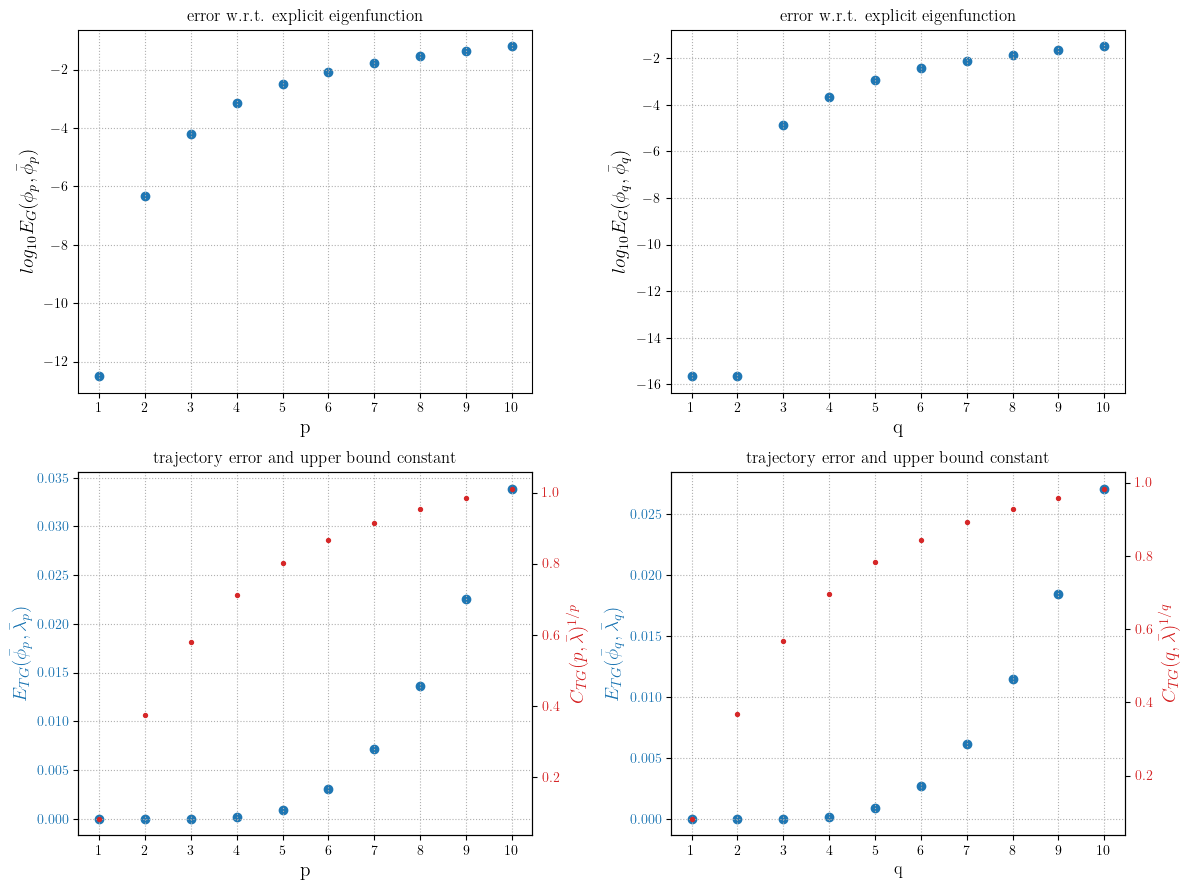

In [31]:
f, ax = plt.subplots(2,2, figsize=(12,9))
plt.subplots_adjust(hspace=0.3, wspace=0.5)

m_list = [d["m"] for d in error_dict if d["n"]==0]
m_c_error = np.array([np.log10(d["c_error"]) for d in error_dict if d["n"]==0])
m_c_error[m_c_error==-np.inf] = np.log10(np.finfo(np.float64).eps)

ax[0][0].scatter(m_list, m_c_error, color="tab:blue")
ax[0][0].set_xlabel('p', fontsize=14)
ax[0][0].set_ylabel('$log_{10}E_G(\phi_p, \\bar{\phi}_p)$', fontsize=14)
ax[0][0].set_title("error w.r.t. explicit eigenfunction")
ax[0][0].set_xticks(m_list)
ax[0][0].grid(linestyle='dotted')


n_list = [d["n"] for d in error_dict if d["m"]==0]
n_c_error = np.array([np.log10(d["c_error"]) for d in error_dict if d["m"]==0])
n_c_error[n_c_error==-np.inf] = np.log10(np.finfo(np.float64).eps)

ax[0][1].scatter(n_list, n_c_error, color="tab:blue")
ax[0][1].set_xlabel('q', fontsize=14)
ax[0][1].set_ylabel('$log_{10}E_G(\phi_q, \\bar{\phi}_q)$', fontsize=14)
ax[0][1].set_title("error w.r.t. explicit eigenfunction")
ax[0][1].set_xticks(n_list)
ax[0][1].grid(linestyle='dotted')


tg_m = np.array([d["traj_error"] for d in error_dict if d["n"]==0])
tg_c_m = [d["traj_bound_const"] for d in error_dict if d["n"]==0]

color = 'tab:blue'
ax[1][0].set_xlabel('p', fontsize=14)
ax[1][0].set_ylabel(r"$E_{TG}(\bar{\phi}_p,  \bar{\lambda}_p)$", color=color, fontsize=14)
ax[1][0].scatter(m_list, tg_m, color=color)
ax[1][0].tick_params(axis='y', labelcolor=color)
ax[1][0].set_xticks(m_list)
ax[1][0].set_title("trajectory error and upper bound constant")
ax[1][0].grid(linestyle='dotted')


ax2 = ax[1][0].twinx()  

color = 'tab:red'
ax2.set_ylabel(r"$C_{TG}(p, \bar{\lambda})^{1/p}$", color=color, fontsize=14)
ax2.scatter(n_list, tg_c_m, color=color, s=8)
ax2.tick_params(axis='y', labelcolor=color)
del ax2

# 
n_list = [d["n"] for d in error_dict if d["m"]==0]
tg_n = np.array([d["traj_error"] for d in error_dict if d["m"]==0])
tg_c_n = [d["traj_bound_const"] for d in error_dict if d["m"]==0]

color = 'tab:blue'
ax[1][1].set_xlabel('q', fontsize=12)
ax[1][1].set_ylabel(r"$E_{TG}(\bar{\phi}_q, \bar{\lambda}_q)$", color=color, fontsize=14)
ax[1][1].scatter(n_list, tg_n, color=color)
ax[1][1].tick_params(axis='y', labelcolor=color)
ax[1][1].set_xticks(n_list)
ax[1][1].set_title("trajectory error and upper bound constant")
ax[1][1].grid(linestyle='dotted')

ax2 = ax[1][1].twinx()

color = 'tab:red'
ax2.set_ylabel(r"$C_{TG}(q, \bar{\lambda})^{1/q}$", color=color, fontsize=14)
ax2.scatter(n_list, tg_c_n, color=color, s=8)
ax2.tick_params(axis='y', labelcolor=color)


f.tight_layout()
plt.savefig(f"plots/{nb_fname}/error_DMD_eigfunc_approx.pdf", bbox_inches='tight')
plt.show()
plt.show()

In [32]:
for d in error_dict:
    if d["m"]==0:
        print(str(d["n"]) + " && " + f"{d['traj_bound_const']:.4f}" + "$\\norm{\delta v}$\\\\")

1 && 0.0825$\norm{\delta v}$\\
2 && 0.3689$\norm{\delta v}$\\
3 && 0.5688$\norm{\delta v}$\\
4 && 0.6960$\norm{\delta v}$\\
5 && 0.7822$\norm{\delta v}$\\
6 && 0.8445$\norm{\delta v}$\\
7 && 0.8916$\norm{\delta v}$\\
8 && 0.9286$\norm{\delta v}$\\
9 && 0.9584$\norm{\delta v}$\\
10 && 0.9830$\norm{\delta v}$\\


#### set explicit norm del v and compute bound and trajector error

In [33]:
koopman_eigen_dmd.left_koopman_eigvecs

array([[ 0.70710678,  0.        ],
       [-0.70710678,  1.        ]])

In [34]:
linear_system.trajectory_error_power(koopman_eigen_dmd, x_flat, p=1, eigenvector_index=0, delv_norm=1e-6)

using delvnorm:  1e-06


7.907283545310785e-08

In [35]:
linear_system.trajectory_error_power(koopman_eigen_dmd, x_flat, p=1, eigenvector_index=0)

3.3543895243002456e-16

In [36]:
linear_system.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = 2, eigenval_index=0)

0.3742095910055767

In [37]:
linear_system.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = 2, eigenval_index=0, delv_norm=1e-6)

0.0003742095910055767

In [38]:
error_compute_dict = []
sorted_eig = [(0,i) for i in range(1, 11)] + [(i,0) for i in range(1,11)] 
import random
random.seed(420)

for i, (m,n) in enumerate(sorted_eig):
    
    if n==0:
        traj_error = linear_system.trajectory_error_power(koopman_eigen_dmd, x_flat, p=m, eigenvector_index=0, delv_norm=1e-6)
        traj_bound_const = linear_system.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = m, eigenval_index=0, delv_norm=1e-6)
            
            
    if m==0:
        traj_error = linear_system.trajectory_error_power(koopman_eigen_dmd, x_flat, p=n, eigenvector_index=1, delv_norm=1e-6)
        traj_bound_const = linear_system.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = n, eigenval_index=1, delv_norm=1e-6)


    error_compute_dict.append({"m": m, "n": n, "traj_bound_const": traj_bound_const, "traj_error": traj_error})
    print(m,n, traj_error, traj_bound_const)

using delvnorm:  1e-06
0 1 2.1157777097535707e-08 8.247027829070742e-08
using delvnorm:  1e-06
0 2 0.0003002012980308743 0.00036887708589888
using delvnorm:  1e-06
0 3 0.004487863820809221 0.005687671057187238
using delvnorm:  1.0000000000000002e-06
0 4 0.01367150457127041 0.022008566178295347
using delvnorm:  1e-06
0 5 0.036154968919785216 0.04935608004948489
using delvnorm:  9.999999999999997e-07
0 6 0.05022836540544889 0.08444916779765244
using delvnorm:  1e-06
0 7 0.09095783708460811 0.12388867269785796
using delvnorm:  1.0000000000000002e-06
0 8 0.1225966317424431 0.1651275171097583
using delvnorm:  9.999999999999997e-07
0 9 0.1283359743386372 0.20648231615262058
using delvnorm:  1.0000000000000002e-06
0 10 0.17012615968158754 0.24691911618710505
using delvnorm:  1e-06
1 0 8.237236128893611e-08 8.247027829070838e-08
using delvnorm:  1e-06
2 0 0.0003016490071461639 0.0003742095910055767
using delvnorm:  1e-06
3 0 0.005160068982818708 0.005797764854240793
using delvnorm:  1e-06
4 0 

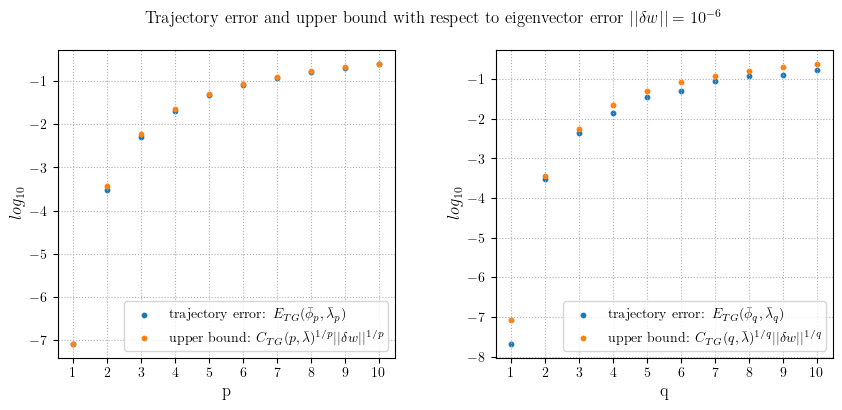

In [39]:
f, ax = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

m_list = [d["m"] for d in error_compute_dict if d["n"]==0]
m_traj_error = np.array([np.log10(d["traj_error"]) for d in error_compute_dict if d["n"]==0])
m_traj_bound = np.array([np.log10(d["traj_bound_const"]) for d in error_compute_dict if d["n"]==0])

ax[0].scatter(m_list, m_traj_error, s=10,  label="trajectory error: $E_{TG}(\\bar{\phi}_p, \\bar{\lambda}_p)$")
ax[0].scatter(m_list, m_traj_bound, s=10,  label="upper bound: $C_{TG}(p, \\bar{\lambda})^{1/p} ||\delta w||^{1/p}$")
ax[0].set_xlabel('p', fontsize=12)
ax[0].set_ylabel('$log_{10}$', fontsize=12)
ax[0].set_xticks(m_list)
ax[0].grid(linestyle='dotted')
ax[0].legend()

n_list = [d["n"] for d in error_compute_dict if d["m"]==0]
n_traj_error = np.array([np.log10(d["traj_error"]) for d in error_compute_dict if d["m"]==0])
n_traj_bound = np.array([np.log10(d["traj_bound_const"]) for d in error_compute_dict if d["m"]==0])

ax[1].scatter(n_list, n_traj_error, s=10, label="trajectory error: $E_{TG}(\\bar{\phi}_q, \\bar{\lambda}_q)$")
ax[1].scatter(n_list, n_traj_bound, s=10, label="upper bound: $C_{TG}(q, \\bar{\lambda})^{1/q} ||\delta w||^{1/q}$")
ax[1].set_xlabel('q', fontsize=12)
ax[1].set_ylabel('$log_{10}$', fontsize=12)
ax[1].set_xticks(n_list)
ax[1].legend()
ax[1].grid(linestyle='dotted')

f.suptitle("Trajectory error and upper bound with respect to eigenvector error $||\delta w||=10^{-6}$")

plt.savefig(f"plots/{nb_fname}/error_del_106_DMD_poly_eigfunc_approx.pdf", bbox_inches='tight')
plt.show()

### Algorithm for deciding powers to extend eigenfunctions

In [40]:
epsilon = 1e-1
delv_norm = 1e-7
algorithm_list = []

for m in range(1, 11):
    c_Tg_p = linear_system.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = m, eigenval_index=0)
    etg = linear_system.trajectory_error_power(koopman_eigen_dmd, x_flat, p=m, eigenvector_index=0, delv_norm=delv_norm)
    
    print("m: ", m, (epsilon/c_Tg_p)**m, delv_norm < (epsilon/c_Tg_p)**m, etg < epsilon, epsilon - etg)
    algorithm_list.append({"m":m, "n":0, "algo_upper_bound": (epsilon/c_Tg_p)**m, "traj_error" : etg})
    
for n in range(1, 11):
    c_Tg_p = linear_system.trajectory_bound_const(koopman_eigen_dmd, x_flat, p = n, eigenval_index=1)
    etg = linear_system.trajectory_error_power(koopman_eigen_dmd, x_flat, p=n, eigenvector_index=1, delv_norm=delv_norm)
    
    print("n: ", n, (epsilon/c_Tg_p)**n, delv_norm < (epsilon/c_Tg_p)**n, etg < epsilon, epsilon - etg)
    algorithm_list.append({"m":0, "n":n, "algo_upper_bound": (epsilon/c_Tg_p)**n, "traj_error" : etg})

using delvnorm:  1e-07
m:  1 1.2125580520960437 True True 0.09999999179402266
using delvnorm:  1e-07
m:  2 0.07141183147481857 True True 0.09990174991767048
using delvnorm:  9.999999999999998e-08
m:  3 0.005131191323486646 True True 0.0976535214401861
using delvnorm:  1.0000000000000001e-07
m:  4 0.00039078073805456833 True True 0.08849366877359036
using delvnorm:  1.0000000000000001e-07
m:  5 3.0379111485219983e-05 True True 0.0700078063061481
using delvnorm:  1e-07
m:  6 2.3788398759791975e-06 True True 0.04377056656674666
using delvnorm:  9.999999999999998e-08
m:  7 1.8667487177219198e-07 True True 0.014576696024523689
using delvnorm:  1e-07
m:  8 1.4651586941315971e-08 False False -0.023342787185544417
using delvnorm:  9.999999999999998e-08
m:  9 1.1493463024965411e-09 False False -0.0571967384856244
using delvnorm:  9.999999999999998e-08
m:  10 9.009209166704287e-11 False False -0.09727505056946964
using delvnorm:  1e-07
n:  1 1.212558052096058 True True 0.09999999178578604
using 

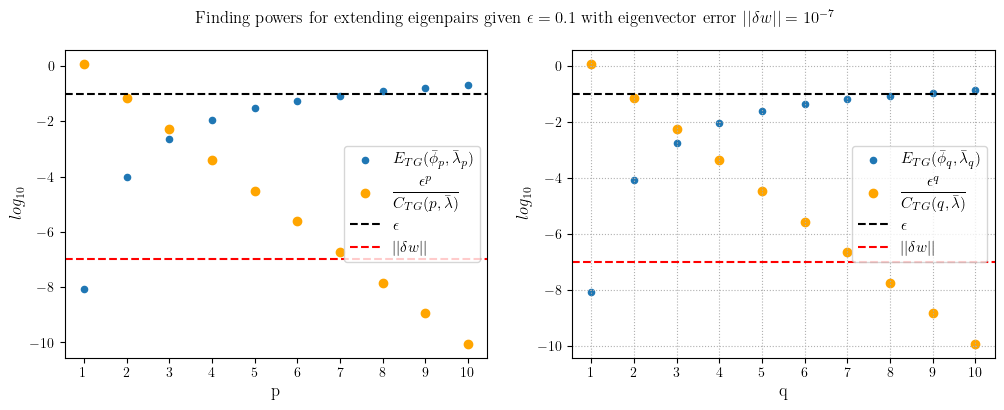

In [42]:
f,ax = plt.subplots(1,2, figsize=(12,4))

m_list = [a["m"] for a in algorithm_list if a["n"]==0]
m_etg =  [a["traj_error"] for a in algorithm_list if a["n"]==0]
m_upper = [a["algo_upper_bound"] for a in algorithm_list if a["n"]==0]
ax[0].scatter(m_list, np.log10(m_etg), label=r"$E_{TG}(\bar{\phi}_p, \bar{\lambda}_p)$", s=20)
ax[0].scatter(m_list, np.log10(m_upper), label=r"$\dfrac{\epsilon^p}{C_{TG}(p, \bar{\lambda})}$", c="orange")
ax[0].axhline(np.log10(epsilon), linestyle = '--', c="black", label=r"$\epsilon$")
ax[0].axhline(np.log10(delv_norm), linestyle = '--', c="red", label=r"$||\delta w||$")

ax[0].set_ylabel("$log_{10}$", fontsize=12)
ax[0].set_xlabel("p", fontsize=12)
ax[0].set_xticks(m_list)
ax[1].grid(linestyle='dotted')
ax[0].legend(fontsize=11)

n_list = [a["n"] for a in algorithm_list if a["m"]==0]
n_etg =  [a["traj_error"] for a in algorithm_list if a["m"]==0]
n_upper = [a["algo_upper_bound"] for a in algorithm_list if a["m"]==0]
ax[1].scatter(m_list, np.log10(n_etg), label=r"$E_{TG}(\bar{\phi}_q, \bar{\lambda}_q)$", s=20)
ax[1].scatter(n_list, np.log10(n_upper), label=r"$\dfrac{\epsilon^q}{C_{TG}(q,\bar{\lambda})}$", c="orange")
ax[1].axhline(np.log10(epsilon), linestyle = '--', c="black",  label=r"$\epsilon$")
ax[1].axhline(np.log10(delv_norm), linestyle = '--', c="red", label=r"$||\delta w||$")
ax[1].set_ylabel("$log_{10}$", fontsize=12)
ax[1].set_xlabel("q", fontsize=12)
ax[1].set_xticks(n_list)
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=11)


f.suptitle("Finding powers for extending eigenpairs given $\epsilon=0.1$ with eigenvector error $||\delta w|| = 10^{-7}$")
plt.savefig(f"plots/{nb_fname}/algorithm_eps_106_del_107_DMD_eigfunc_extend.pdf", bbox_inches='tight')

plt.show()


### reconstructing observables using new eigenfunctions

In [43]:
sinx_df = np.sin(tsc_data).to_numpy()
sinx_df.shape

(800, 2)

#### reconstruct sinx using in-sample data

In [44]:
eigfunc_matrix = koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs)(tsc_data.to_numpy())
eigfunc_matrix.shape

(800, 2)

In [45]:
sinx_recons_df = koopman_eigen_dmd.reconstruct_observable(sinx_df, eigfunc_matrix)
sinx_recons_df.shape

(800, 2)

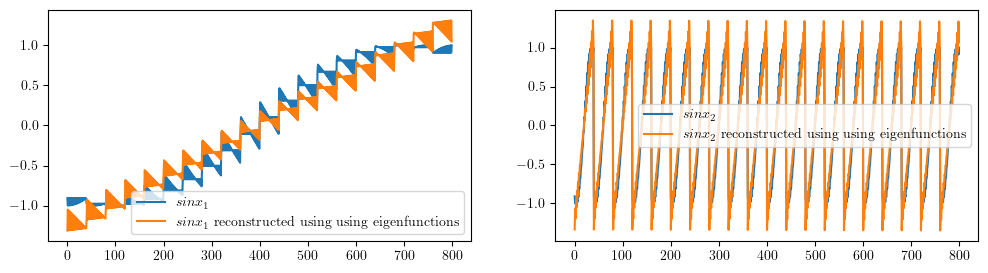

In [46]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

ax[0].plot(sinx_df[:,0], label="$sin x_1$")
ax[0].plot(sinx_recons_df[:,0], label="$sinx_1$ reconstructed using using eigenfunctions")
ax[0].legend()

ax[1].plot(sinx_df[:,1], label="$sinx_2$")
ax[1].plot(sinx_recons_df[:,1], label="$sinx_2$ reconstructed using using eigenfunctions")
ax[1].legend()


#### reconstruct sinx using out of sample data

In [47]:
x = np.linspace(-3*np.pi, 3*np.pi, 100)
y = np.linspace(-3*np.pi, 3*np.pi, 100)

oos_grid = np.array([x, y]).T
sinx_oos_grid = np.sin(oos_grid)

eigfunc_matrix = koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs)(oos_grid)
eigfunc_matrix.shape

(100, 2)

In [48]:
sinx_oos_recons_orig = koopman_eigen_dmd.reconstruct_observable(sinx_oos_grid, eigfunc_matrix)
sinx_oos_recons_orig.shape

(100, 2)

In [49]:
exp_pairs = [(i,j) for i in range(0,4) for j in range(0,4)]

eigfunc_matrix = koopman_eigen_dmd.extended_eigfunction_matrix(oos_grid,eigvector_idx = [0,1], exp_pairs=exp_pairs)
print(f"extended eigenfunction matrix shape: ", eigfunc_matrix.shape)

sinx_oos_recons_14 = koopman_eigen_dmd.reconstruct_observable(sinx_oos_grid, eigfunc_matrix)
print("reconstructed observable shape: ", sinx_oos_recons_14.shape)

extended eigenfunction matrix shape:  (100, 15)
reconstructed observable shape:  (100, 2)


#### reconstruct using an extended set of eigenfunctions

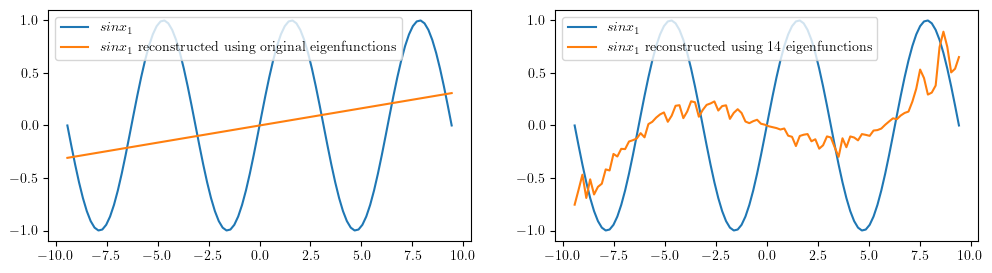

In [50]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

ax[0].plot(oos_grid[:,0], sinx_oos_grid[:,0], label="$sin x_1$")
ax[0].plot(oos_grid[:,0], sinx_oos_recons_orig[:,0], label="$sinx_1$ reconstructed using original eigenfunctions")
ax[0].legend()

ax[1].plot(oos_grid[:,0], sinx_oos_grid[:,0], label="$sin x_1$")
ax[1].plot(oos_grid[:,0], sinx_oos_recons_14[:,0], label="$sinx_1$ reconstructed using 14 eigenfunctions")
ax[1].legend()

#### reconstructing sin(x1)cos(x2)

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data for the contour plot
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

oos_grid = np.array([X.flatten(), Y.flatten()]).T
sincos_oos_grid = (np.sin(X) * np.cos(Y)).flatten()
oos_grid.shape, sincos_oos_grid.shape

((10000, 2), (10000,))

In [52]:
eigfunc_matrix = koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs)(oos_grid)

sincos_oos_recons_orig = koopman_eigen_dmd.reconstruct_observable(sincos_oos_grid, eigfunc_matrix)
sincos_oos_recons_orig.shape

(10000,)

In [53]:
exp_pairs = [(i,j) for i in range(0,4) for j in range(0,4)]

eigfunc_matrix = koopman_eigen_dmd.extended_eigfunction_matrix(oos_grid, eigvector_idx = [0,1], exp_pairs=exp_pairs)
print("eigenfunction matrix shape: ", eigfunc_matrix.shape)

sincos_oos_recons_14 = koopman_eigen_dmd.reconstruct_observable(sincos_oos_grid, eigfunc_matrix)
print("reconstructed observable shape: ", sincos_oos_recons_14.shape)

eigenfunction matrix shape:  (10000, 15)
reconstructed observable shape:  (10000,)


In [54]:
exp_pairs = [(i,j) for i in range(0,5) for j in range(0,5)]

eigfunc_matrix = koopman_eigen_dmd.extended_eigfunction_matrix(oos_grid, eigvector_idx = [0,1], exp_pairs=exp_pairs)
print("eigenfunction matrix shape: ", eigfunc_matrix.shape)

sincos_oos_recons_24 = koopman_eigen_dmd.reconstruct_observable(sincos_oos_grid, eigfunc_matrix)
print("reconstructed observable shape: ", sincos_oos_recons_24.shape)

eigenfunction matrix shape:  (10000, 24)
reconstructed observable shape:  (10000,)


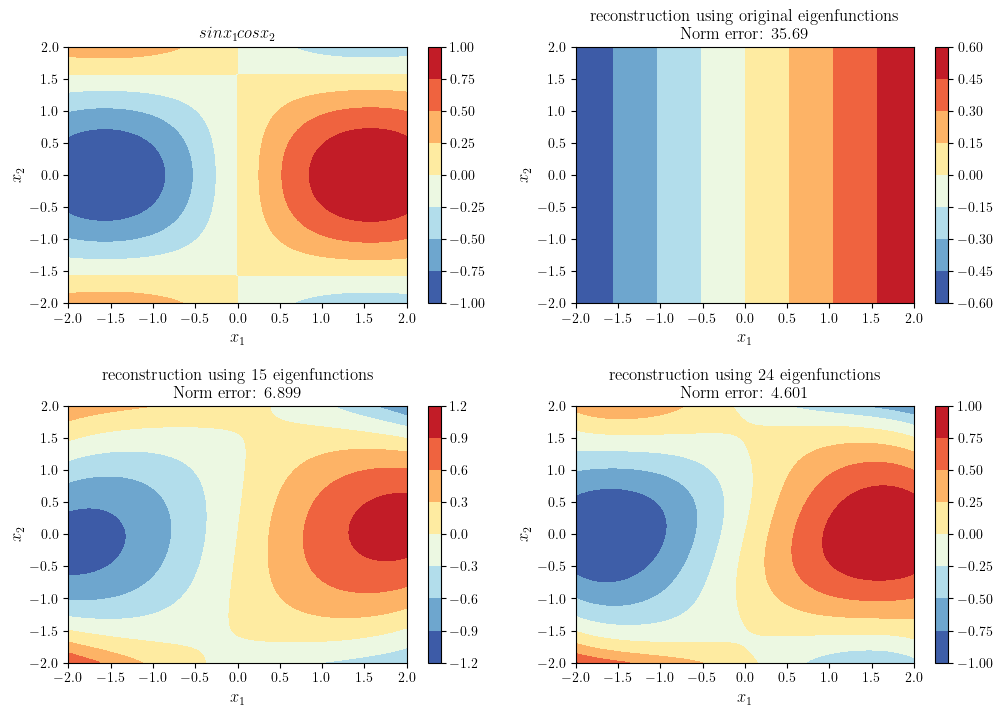

In [55]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.subplots_adjust(hspace=0.4)


h = ax[0][0].contourf(X, Y, sincos_oos_grid.reshape(100,100), cmap='RdYlBu_r')
ax[0][0].set_title("$sinx_1cosx_2$", fontsize=12)
ax[0][0].set_xlabel('$x_1$', fontsize=12)
ax[0][0].set_ylabel('$x_2$', fontsize=12)

plt.colorbar(h)

k = ax[0][1].contourf(X, Y, sincos_oos_recons_orig.reshape(100,100), cmap='RdYlBu_r')
ax[0][1].set_title(f"reconstruction using original eigenfunctions\nNorm error: {np.linalg.norm(sincos_oos_grid-sincos_oos_recons_orig):.4}",
                   fontsize=12)
ax[0][1].set_xlabel('$x_1$', fontsize=12)
ax[0][1].set_ylabel('$x_2$', fontsize=12)

plt.colorbar(k)

l = ax[1][0].contourf(X, Y, sincos_oos_recons_14.reshape(100,100), cmap='RdYlBu_r')
ax[1][0].set_title(f"reconstruction using 15 eigenfunctions\nNorm error: {np.linalg.norm(sincos_oos_grid-sincos_oos_recons_14):.4}",
                  fontsize=12)
ax[1][0].set_xlabel('$x_1$', fontsize=12)
ax[1][0].set_ylabel('$x_2$', fontsize=12)

plt.colorbar(l)

m = ax[1][1].contourf(X, Y, sincos_oos_recons_24.reshape(100,100), cmap='RdYlBu_r')
ax[1][1].set_title(f"reconstruction using 24 eigenfunctions\nNorm error: {np.linalg.norm(sincos_oos_grid-sincos_oos_recons_24):.4}",
                  fontsize=12)
ax[1][1].set_xlabel('$x_1$', fontsize=12)
ax[1][1].set_ylabel('$x_2$', fontsize=12)
plt.colorbar(m)

plt.savefig(f"plots/{nb_fname}/sinxcos1_reconstruction_DMD_linear_system.pdf", bbox_inches='tight')
plt.show()